In [2]:
import torch
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances 
from scipy.spatial import distance_matrix
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
from scipy.spatial.distance import pdist


Infer Gaussian parameters with Scoring Rules

In [3]:
def Variogram_single_day(observations_y,simulations_Y,distance_matrix):
    n = len(observations_y)
    m = len(simulations_Y)
    y = np.array(observations_y)
    Y = np.array(simulations_Y)
    # inverse distance matrix, for weights w_ij:
    w_ij = 1/(distance_matrix+1)
    # |y_i - y_j| first part of Variogram
    diff_y_y = euclidean_distances(y.reshape(-1,1))
    # |Y_k,i - Y_k,j| second part of Variogram
    diff_Y_Y = np.mean(np.abs(np.tile(Y,n).reshape(m,n*n)-np.repeat(Y,n).reshape(m,n*n)),axis=0).reshape(n,n)
    Variogram = np.multiply(w_ij,np.power(diff_y_y - diff_Y_Y,2))
    return np.sum(Variogram)

def variogram(obs,sims,dist_mat,p):
    '''
    Variogram score from eq 10 in Pacchiardi paper [2024 Probabilistic Forecasting with Generative Networks
    via Scoring Rule Minimization] in JMLR.
    
    SR = sum_ij w_ij * (|y_i - y_j|^p - |Y_k,i - Y_k,j|^p)^2
    '''
    obs = np.array(obs)
    sims = np.array(sims)
    n = len(obs)
    m = len(sims)
    w_ij = 1/(dist_mat+1)
    SR = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            diff_y_y = np.power(np.abs(obs[i]-obs[j]),p)
            #diff_Y_Y = np.power(sims[:,i]-sims[:,j],p).sum()/m
            diff_Y_Y=0
            for k in range(m):
                diff_Y_Y += np.power(np.abs(sims[k,i]-sims[k,j]),p)
            diff_Y_Y /= m
            SR[i,j] = w_ij[i,j]*((diff_y_y - diff_Y_Y)**2)
    return SR.sum()

def  naive_version(obs,sims,dist_mat,p):
    score = 0
    data_size = len(obs)
    dist_mat_ = 1/(dist_mat+1)
    ensemble_size = len(sims)
    for i in range(data_size):
        for j in range(data_size):
            diff_obs = np.power(np.abs(obs[i] - obs[j]), p)
            diff_for=0
            for e in range(ensemble_size):
                diff_for += np.power(np.abs(sims[ e, i] - sims[e, j]), p)
            diff_for /= ensemble_size

            score += dist_mat_[i, j] * np.power(diff_obs - diff_for, 2)
    return score

def Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy

locs = np.meshgrid(np.array([0,1,2,3]),np.array([0,1,2,3]).T)
locs = np.vstack((locs[0].flatten(),locs[1].flatten())).T
dist_mat = distance_matrix(locs,locs)
true_cov = RBF(3).__call__(dist_mat)
obs = scs.multivariate_normal.rvs(mean=np.zeros(16), cov=true_cov, size=1)

In [379]:
np.linalg.norm(
                np.tile(np.array([1,2,3,4]),(4,1))
 - np.zeros((4,4)),axis=1)

array([5.47722558, 5.47722558, 5.47722558, 5.47722558])

100%|██████████| 20/20 [00:00<00:00, 367.45it/s]


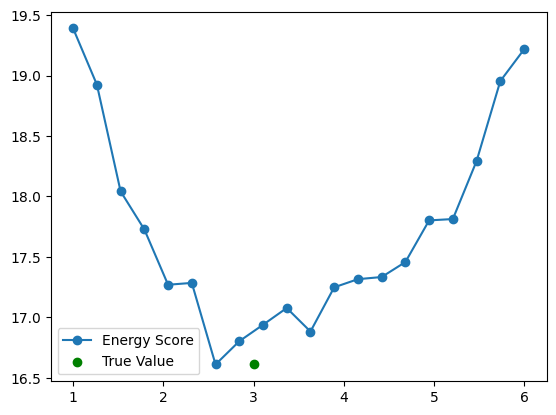

In [456]:
SR_e = []
obs_z = scs.norm.rvs(loc=0,scale=3,size=16)
for i in tqdm(np.linspace(1,6,20)):

    SR_e.append(Energy_Score(1,obs_z,scs.norm.rvs(loc=0,scale=i,size=(16,500)).T))

plt.plot(np.linspace(1,6,20),SR_e,'-o',label='Energy Score')
plt.scatter(3,np.min(SR_e),color='green',label='True Value',zorder=10)
plt.legend()
plt.show()

In [5]:
obs_z = scs.multivariate_normal.rvs(mean=np.zeros(16), cov=true_cov, size=5)


100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


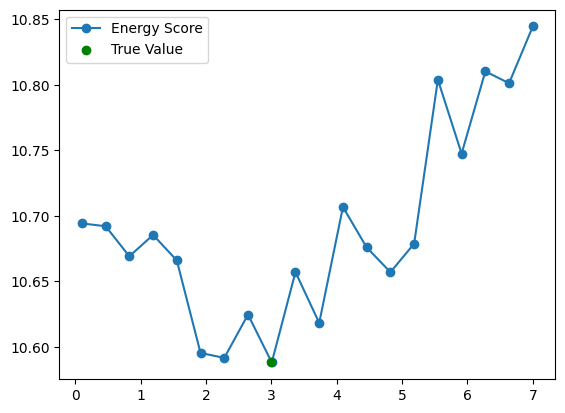

In [546]:
# multivariate normal
SR_e = []
mean = np.zeros(16)
for i in tqdm(np.linspace(0.1,7,20)):
    cov_ = RBF(i).__call__(dist_mat)
    temp_ = 0
    for k in range(len(obs_z)):
        temp_ += Energy_Score(0.5,obs_z[k],scs.multivariate_normal.rvs(mean=mean, cov=cov_, size=1000))
    SR_e.append(temp_.mean())
plt.plot(np.linspace(0.1,7,20),SR_e,'-o',label='Energy Score')
plt.scatter(3,np.min(SR_e),color='green',label='True Value',zorder=10)
plt.legend()
plt.show()

In [14]:
obs_z = scs.multivariate_normal.rvs(mean=np.zeros(16), cov=true_cov*3, size=20)


100%|██████████| 20/20 [02:19<00:00,  6.98s/it]


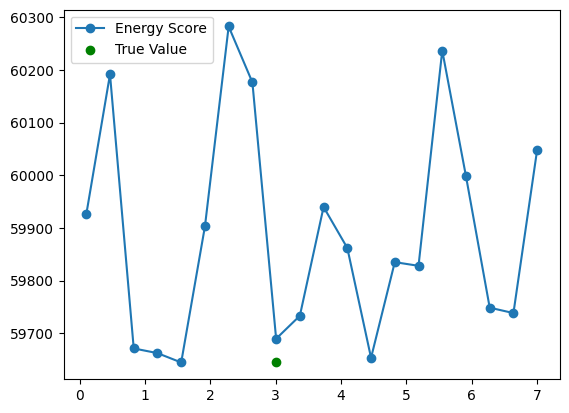

In [15]:
# multivariate normal
SR_e = []
mean = np.zeros(16)
for i in tqdm(np.linspace(0.1,7,20)):
    temp_ = 0
    for k in range(len(obs_z)):
        temp_ += variogram(obs_z[k],scs.multivariate_normal.rvs(mean=mean, cov=true_cov*3, size=600),dist_mat,2)
    SR_e.append(temp_.mean())
plt.plot(np.linspace(0.1,7,20),SR_e,'-o',label='Energy Score')
plt.scatter(3,np.min(SR_e),color='green',label='True Value',zorder=10)
plt.legend()
plt.show()